# Database Exploration

This notebook allows for easy exploration of the contents of the /data folder.

It is mainly design for use with the Ninapro databases and databases which are setup in similar fashion.

In [1]:
import src
from scipy.io import loadmat, whosmat
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd
import plotly.express as px
from src import config
import os
import re

In [2]:
# Choose the database to analyze
database = 'DB6'

data_path = f'data/{database}'

# Find the folder named with the convention s + "number"
folder = None
for item in os.listdir(data_path):
    if re.match(r'[sS]\d+', item) or re.match(r'Subject\d+', item):
        folder = item
        break

if folder:
    folder_path = os.path.join(data_path, folder)
    results = []

    # Iterate over all .mat files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(folder_path, file_name)
            info = whosmat(file_path)
            results.append((file_name, info))

    # Create a DataFrame to store the results
    data = {}
    for file_name, info in results:
        for item in info:
            if item[0] not in data:
                data[item[0]] = {}
            data[item[0]][file_name] = item[1:]

    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns.name = 'File Name'

    print(df)
else:
    print("No folder found with the convention s + 'number'")

File Name                     S4_D2_T2.mat             S4_D4_T2.mat  \
repetition            ((1422970, 1), int8)     ((1424748, 1), int8)   
repetition_object     ((1422970, 1), int8)     ((1424748, 1), int8)   
acc                ((1422970, 48), single)  ((1424748, 48), single)   
daytesting                ((1, 1), double)         ((1, 1), double)   
emg                ((1422970, 16), single)  ((1424748, 16), single)   
object                ((1422970, 1), int8)     ((1424748, 1), int8)   
reobject              ((1422970, 1), int8)     ((1428342, 1), int8)   
rerepetition          ((1422970, 1), int8)     ((1424748, 1), int8)   
restimulus            ((1422970, 1), int8)     ((1424748, 1), int8)   
stimulus              ((1422970, 1), int8)     ((1424748, 1), int8)   
subj                      ((1, 1), double)         ((1, 1), double)   
time                      ((1, 1), double)         ((1, 1), double)   

File Name                     S4_D1_T2.mat             S4_D1_T1.mat  \
repet

In [3]:
mat_file = src.loadmatNina(database, "S4_D2_T2.mat", subject='s4')

Loaded file: S4_D2_T2.mat
Total test time: 711.485 seconds
Total test time: 11.858083333333333 minutes
Unique restimulus values: [ 0  1  3  4  6  9 10 11]
Total EMG samples: 22767520.0
Frequency: 2000 Hz
Summary for the whole file:
       __globals__    repetition  repetition_object           acc  daytesting  \
count          0.0  1.422970e+06       1.422970e+06  6.830256e+07         1.0   
mean           NaN  3.743958e+00       1.855025e+00 -6.858099e-02         2.0   
std            NaN  4.142646e+00       3.014767e+00  5.311221e-01         NaN   
min            NaN  0.000000e+00      -1.000000e+00 -2.069717e+00         2.0   
25%            NaN  0.000000e+00      -1.000000e+00 -4.422547e-01         2.0   
50%            NaN  2.000000e+00       1.000000e+00  0.000000e+00         2.0   
75%            NaN  7.000000e+00       4.000000e+00  1.761816e-01         2.0   
max            NaN  1.200000e+01       1.200000e+01  2.011316e+00         2.0   

                emg        object     

Rest included in the movement extraction!
Filtered EMG data shape: (200448, 16)
Filtered restimulus data shape: (200448, 1)
test time: 100.224 seconds
Number of Repetitions: 12


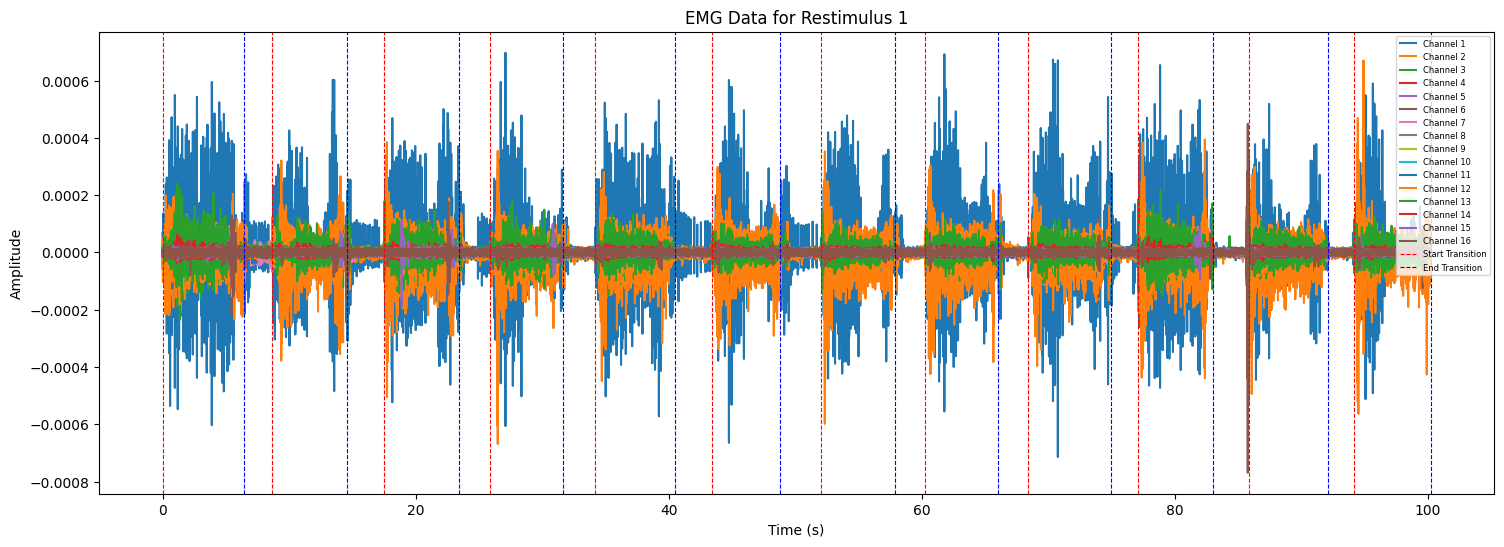

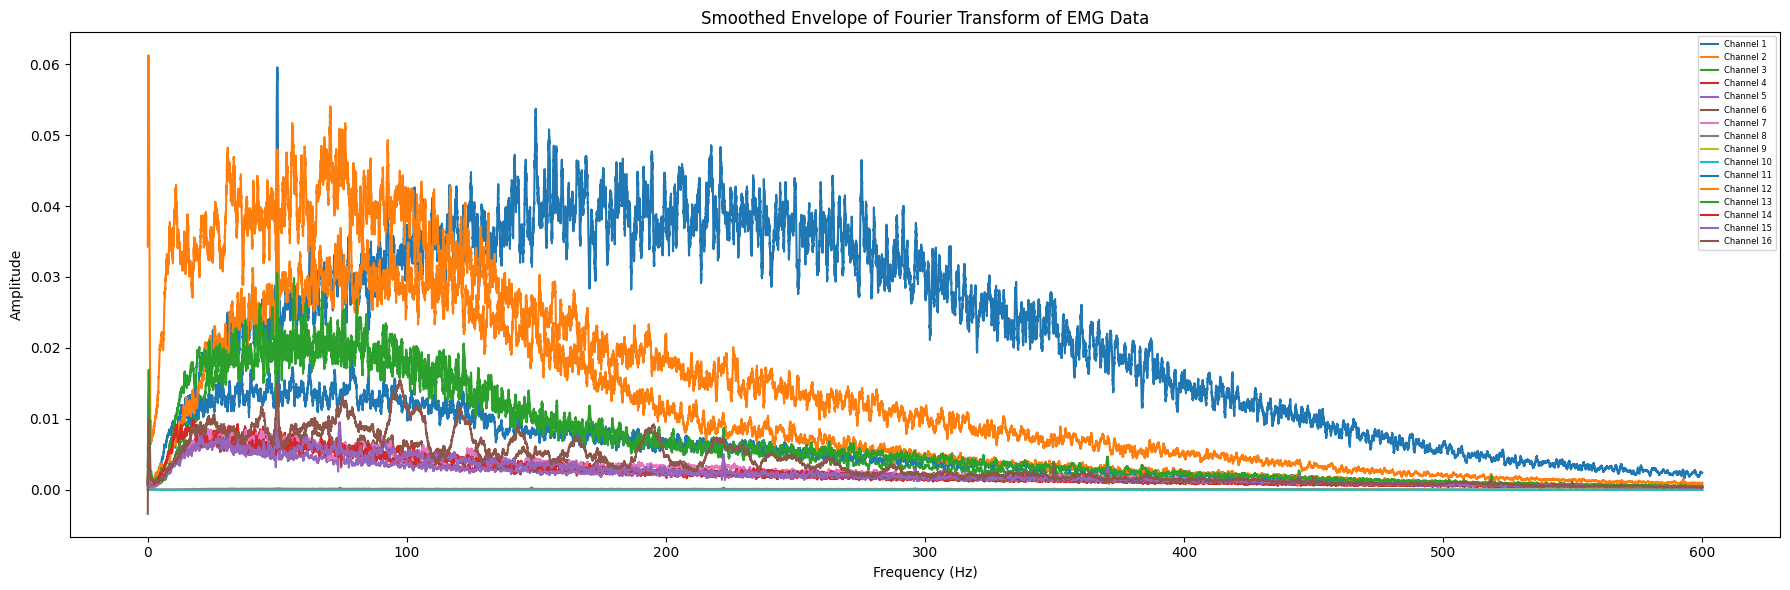

In [4]:
src.plot_emg_data(database, mat_file, 1, interactive=False, include_rest=True, use_stimulus=False, addFourier = True)

In [5]:
#Routine to create data frame with characteristics and labels.
databases = config.DATABASES
fc= config.FC #Cutoff frequency in Hz
windowing = config.WINDOWING #s time of the window // Ej: 0.2s = 200 ms
overlapping = config.OVERLAPPING #% overlapping percentage
repetitions = config.REPETITIONS #Number of times a movement is repeated
electrodes = config.ELECTRODES #Number of electrodes used in the experiment
threshold = config.THRESHOLD # Characterization percentage
for database, fm in databases.items(): #Iterates over databases
    window_length = int(windowing * fm)
    subjects = src.get_file_path_database(database)
    for individual in subjects: #Iterates over individuals in the experiments
        mat_file = loadmat(individual)
        emg = mat_file['emg']
        re_stimulus = mat_file['restimulus']
        re_repetition = mat_file['rerepetition']
        start_index_re_stimulus, end_index_re_stimulus = src.get_stimulus_index(re_stimulus) # Get the start and end index of the entire set of repetitions for an exercise.
        filtered_start_index_re_stimulus = src.get_start_end_index(
            start_index_re_stimulus, 
            end_index_re_stimulus, 
            movements_as_integers, 
            repetitions
        ) #Get the segments of the entire set of repetitions for an exercise. 
        for movement in movements_as_integers: #Iterates over the movements implied in the classification 
            if movement == 0:
                continue
            segmented_re_stimulus = src.get_signal_by_movement_complete(re_stimulus, filtered_start_index_re_stimulus[str(movement)]) #Gets the signal of the movement
            windows_re_stimulus = src.create_windows_with_overlap(segmented_re_stimulus, window_length, overlapping)
            labels = []
            for window in windows_re_stimulus:
                label = src.get_label(window, threshold, movements_label, database)
                labels.append(label)
            emg_signals = []
            for electrode in range(electrodes):
                segmented_emg_signal = src.get_signal_by_movement_complete(emg[:, electrode], filtered_start_index_re_stimulus[str(movement)])
                filtered_segmented_emg_signal = src.get_envelope_filtered(segmented_emg_signal, fc, fm)
                windows_emg_electrode = src.create_windows_with_overlap(filtered_segmented_emg_signal, window_length, overlapping)
                emg_signals.append(windows_emg_electrode)
            windows_quantity  = len(emg_signals[0])
            if (windows_quantity != len(labels)):
                print('Different longitude in labels with electrodes', movement, individual, database) #This is used to check the windows between labels and windows in electrodes
                raise ValueError('No es compatible')
            for index_label,label in enumerate(labels):
                if not label:
                    print(label)
                data_label = {
                    'label': label,
                }
                for index_electrode, element in enumerate(emg_signals):
                    if len(element) != windows_quantity:
                        print('Different longitude in electrodes', index_electrode, movement, individual, database) #This is used to find any signal with different number of window
                        raise ValueError('No es compatible')
                    for feature, function in features.items():
                        feature_calculus = function(element[index_label])
                        data_label[feature+str(index_electrode+1)] = np.array([feature_calculus])
                new_data_label = pd.DataFrame(data_label)
                signals_features = pd.concat([signals_features, new_data_label], ignore_index=True)


AttributeError: module 'src.config' has no attribute 'DATABASES'